In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.gridspec as gridspec

import sys
sys.path.append('../src')  # Go one level up and then into src
from SMF import SMF_BCD, SMF_LPGD, rank_r_projection, compute_accuracy_metrics
from SMF_torch import smf

# Microarray Cancer Data

## Read data

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("whitegrid")

#sys.path.append('../data')  # Go one level up and then into src

"""
data = pd.read_csv('../Data/Breast_GSE70947.csv')
y = data['type'].values
y = [1 if y[i] == 'breast_adenocarcinoma' else 0 for i in range(len(y))]
X = data.drop(columns=['samples', 'type']).values
X = (X - np.mean(X, axis = 0))/(100*np.std(X, axis = 0)) # normalization
print("X.shape=", X.shape)

"""

data = pd.read_csv('../Data/Pancreatic_GSE16515.csv')
y = data['type'].values
y = [1 if y[i] == 'tumoral' else 0 for i in range(len(y))]
y = np.array(y)
X0 = data.drop(columns=['samples', 'type']).values
X = (X0 - np.mean(X0, axis = 0))/(100*np.std(X0, axis = 0)) # normalization
#X = 10*X0/np.linalg.norm(X0)
print("X.shape=", X.shape) # X.shape = [num of samples, num of features]
print("y.shape=", y.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train, X_test = X_train.T, X_test.T
Y_train, Y_test = np.asarray([Y_train]), np.asarray([Y_test])
covariate_train, covariate_test = None, None

gene_list0 = data.keys()
gene_list = gene_list0[2:]

X.shape= (51, 54675)
y.shape= (51,)


## SMF-W

### Use Block Coordiante Descent to fit SMF-W

In [11]:
r = 2 # number of latent gene groups
xi = 1 # supervision parameter (weight for the matrix factorization loss)
iteration = 100


U0, S0, H0, recons = rank_r_projection(X_train, r)
W0 = U0 @ np.diag(S0) # initial filters = latent gene groups 
W0 = [W0, 1-2*np.random.rand(Y_train.shape[0], r + 1)] # initial filters + regression coefficients

SMF_BCD_class = SMF_BCD(X=[X_train, Y_train],  # data, label
                            X_test=[X_test, Y_test], 
                            n_components=r,  
                            ini_loading=W0,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                            # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                            ini_code = H0,
                            xi=xi,  # weight on label reconstruction error
                            nonnegativity=[False,False,False]) # nonnegativity constraints on code H, dictionary W[0], reg params W[1]

results_dict = SMF_BCD_class.fit(iter=iteration, subsample_size=None,
                                    option = "filter",
                                    if_compute_recons_error=True, if_validate=False)

results_dict.update({'method': 'SMF-W'})
results_dict.update({'r': r})
results_dict.update({'xi': xi})
results_dict.update({'nu': None})

initial loading beta [[-0.38428877 -0.50518752  0.48957759]]


  1%|          | 1/100 [00:00<00:48,  2.04it/s]

--- Training --- [threshold, AUC] =  [0.742, 0.917]
--- Iteration 0: Training loss --- [Data, Label, Total] = [94.627142.3, 10.487566.3, 105.114707.3]


 11%|█         | 11/100 [00:13<02:13,  1.49s/it]

--- Training --- [threshold, AUC] =  [0.643, 0.931]
--- Iteration 10: Training loss --- [Data, Label, Total] = [89.148516.3, 9.347485.3, 98.496001.3]


 21%|██        | 21/100 [00:28<02:07,  1.61s/it]

--- Training --- [threshold, AUC] =  [0.642, 0.944]
--- Iteration 20: Training loss --- [Data, Label, Total] = [89.373118.3, 8.823386.3, 98.196503.3]


 31%|███       | 31/100 [00:41<01:33,  1.36s/it]

--- Training --- [threshold, AUC] =  [0.566, 0.951]
--- Iteration 30: Training loss --- [Data, Label, Total] = [89.537826.3, 8.465449.3, 98.003275.3]


 41%|████      | 41/100 [00:53<01:29,  1.51s/it]

--- Training --- [threshold, AUC] =  [0.567, 0.951]
--- Iteration 40: Training loss --- [Data, Label, Total] = [89.659943.3, 8.209197.3, 97.869140.3]


 51%|█████     | 51/100 [01:04<01:01,  1.25s/it]

--- Training --- [threshold, AUC] =  [0.568, 0.951]
--- Iteration 50: Training loss --- [Data, Label, Total] = [89.753197.3, 8.019019.3, 97.772216.3]


 61%|██████    | 61/100 [01:18<01:01,  1.58s/it]

--- Training --- [threshold, AUC] =  [0.569, 0.958]
--- Iteration 60: Training loss --- [Data, Label, Total] = [89.826271.3, 7.873552.3, 97.699823.3]


 71%|███████   | 71/100 [01:33<00:41,  1.43s/it]

--- Training --- [threshold, AUC] =  [0.569, 0.958]
--- Iteration 70: Training loss --- [Data, Label, Total] = [89.884772.3, 7.759366.3, 97.644138.3]


 81%|████████  | 81/100 [01:45<00:18,  1.05it/s]

--- Training --- [threshold, AUC] =  [0.57, 0.958]
--- Iteration 80: Training loss --- [Data, Label, Total] = [89.932469.3, 7.669088.3, 97.601557.3]


 91%|█████████ | 91/100 [01:48<00:04,  1.98it/s]

--- Training --- [threshold, AUC] =  [0.57, 0.965]
--- Iteration 90: Training loss --- [Data, Label, Total] = [89.971836.3, 7.594464.3, 97.566300.3]


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.571, 0.965]


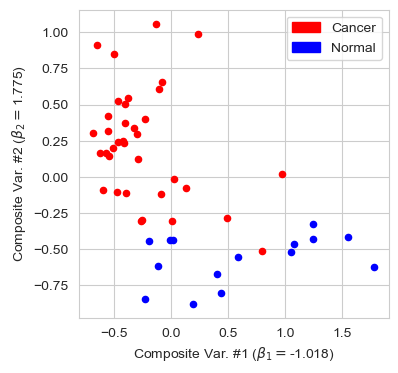

In [12]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[4,4], constrained_layout=False)
outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)
inner_grid = outer_grid[0,0].subgridspec(1, 1, wspace=0, hspace=0)
ax = fig.add_subplot(inner_grid[0, 0])
colors = ["r", "b"]

W = results_dict.get("loading")[0]
Beta = results_dict.get("loading")[1]
X_comp = W.T @ X.T

for i in np.arange(len(y)):
    x1 = X_comp[0,i]
    x2 = X_comp[1,i]
    label = y[i]
    
    if label == 0:
        ax.scatter(x1, x2, s=20, c="b", alpha=1)
    else:
        ax.scatter(x1, x2, s=20, c="r", alpha=1)
        
red_patch = mpatches.Patch(color='red', label='Cancer')
blue_patch = mpatches.Patch(color='blue', label='Normal')
ax.legend(handles=[red_patch, blue_patch])

beta1 = np.round(Beta[0,1], 3)
beta2 = np.round(Beta[0,2], 3)
ax.set_xlabel(r"Composite Var. #1 ($\beta_{1}=$"+str(beta1) + ")")
ax.set_ylabel(r"Composite Var. #2 ($\beta_{2}=$"+str(beta2) + ")")



plt.savefig("plot1", bbox_inches="tight", dpi=300)

In [13]:
print("latent gene groups = " + "\n" + "{}".format(W))
print("regression coefficients associated to the latent gene groups = {}".format(Beta[0,1:]))
print("intercept term = {}".format(Beta[0,0]))

latent gene groups = 
[[-0.00236304  0.00683895]
 [-0.00316206  0.00223268]
 [-0.00299742  0.00655953]
 ...
 [ 0.00321243 -0.0016584 ]
 [ 0.00354569 -0.00116047]
 [ 0.00207613  0.00149535]]
regression coefficients associated to the latent gene groups = [-1.0175061   1.77539587]
intercept term = 0.8287273094168496


### Use Low-rank Projected Gradient Descent to fit SMF-W

In [6]:
r = 2 # number of latent gene groups
xi = 1 # supervision parameter (weight for the matrix factorization loss)
iteration = 100

U0, S0, H0, recons = rank_r_projection(X_train, r)
W0 = U0 @ np.diag(S0) # initial filters = latent gene groups 
W0 = [W0, 1-2*np.random.rand(Y_train.shape[0], r + 1)] # initial filters + regression coefficients

SMF_LPGD_class = SMF_LPGD(X=[X_train, Y_train],  # data, label
                        X_test=[X_test, Y_test],
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        ini_loading = W0,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        ini_code = H0,
                        xi=xi)  # weight on label reconstruction error
                       

results_dict = SMF_LPGD_class.fit(iter=iteration, 
                                    beta = 0,
                                    nu = 0,
                                    stepsize=0.01,
                                    if_compute_recons_error=False, if_validate=False)

results_dict.update({'method': 'SDL-W'})
results_dict.update({'r': r})
results_dict.update({'xi': xi})
results_dict.update({'nu': None})

initial loading beta [[-0.57119413 -0.54860458  0.01002814]]


100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.631, 0.938]
!!! ACC_list [0.8846153846153846]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.536, 0.967, 0.885, 0.854]


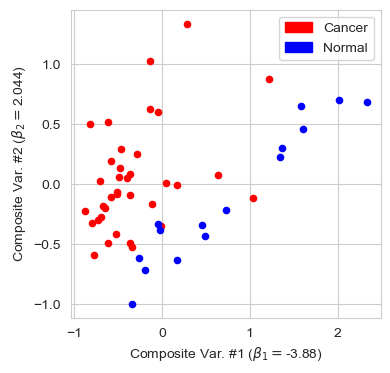

In [ ]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[4,4], constrained_layout=False)
outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)
inner_grid = outer_grid[0,0].subgridspec(1, 1, wspace=0, hspace=0)
ax = fig.add_subplot(inner_grid[0, 0])
colors = ["r", "b"]

W = results_dict.get("loading")[0]
Beta = results_dict.get("loading")[1]
X_comp = W.T @ X.T

for i in np.arange(len(y)):
    x1 = X_comp[0,i]
    x2 = X_comp[1,i]
    label = y[i]
    
    if label == 0:
        ax.scatter(x1, x2, s=20, c="b", alpha=1)
    else:
        ax.scatter(x1, x2, s=20, c="r", alpha=1)
        
red_patch = mpatches.Patch(color='red', label='Cancer')
blue_patch = mpatches.Patch(color='blue', label='Normal')
ax.legend(handles=[red_patch, blue_patch])

beta1 = np.round(Beta[0,1], 3)
beta2 = np.round(Beta[0,2], 3)
ax.set_xlabel(r"Composite Var. #1 ($\beta_{1}=$"+str(beta1) + ")")
ax.set_ylabel(r"Composite Var. #2 ($\beta_{2}=$"+str(beta2) + ")")



plt.savefig("plot2", bbox_inches="tight", dpi=300)

In [7]:
print("latent gene groups = " + "\n" + "{}".format(W))
print("regression coefficients associated to the latent gene groups = {}".format(Beta[0,1:]))
print("intercept term = {}".format(Beta[0,0]))

latent gene groups = 
[[-0.00254567  0.00672494]
 [-0.00325291  0.00215129]
 [-0.00317856  0.0064413 ]
 ...
 [ 0.00329134 -0.00158881]
 [ 0.00361755 -0.00108087]
 [ 0.00207202  0.00151883]]
regression coefficients associated to the latent gene groups = [-1.05987627  1.74533091]
intercept term = 0.8246190756711981


### Use Pytorch implementation of BCD to fit SMF-W (utilizes GPU if possible)

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.autograd import Variable

"""
#data = pd.read_csv('../Data/Pancreatic_GSE16515.csv')
data = pd.read_csv('../Data/Breast_GSE70947.csv')

print(data.shape)
y = data['type'].values
y = [1 if y[i] == 'breast_adenocarcinoma' else 0 for i in range(len(y))]
y = np.array(y)
X = data.drop(columns=['samples', 'type']).values
X = (X - np.mean(X, axis = 0))/(100*np.std(X, axis = 0)) # normalization
"""


hidden_size = 2

Accuracy = []
test_size = 0.5

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=2)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(Y_train)).long()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(Y_test)).long()
print(f"y_train's ndim: {y_train.ndim}")

smf_model = smf(X_train, y_train, hidden_size, device='cuda')
smf_model.fit(num_epochs=10000,
               lr_classification=0.01,
               lr_matrix_factorization=0.01,
               xi=1,
               initialize='spectral',
               W_nonnegativity=True,
               H_nonnegativity=True,
               test_data=[X_test, y_test],
               record_recons_error=True)
Accuracy.append(smf_model.test(X_test, y_test))

y_train's ndim: 1
--- Training --- [threshold, AUC] =  [inf, 0.181]
--- Iteration -1: Training loss --- [Data, Label, Total] = [80.222993.3, 18.785383.3, 99.008377.3]


/Users/yee/Code/SMF_BCD/SMF/notebooks/../src/SMF_torch.py:458: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Epoch [10/10000],Elapsed_time: 0.8612143993377686,Loss_Classification: 50.3742 Loss_MF: 0.0001
mythre= inf
mythre_test= 0.62241703
Test accuracy = 0.231, Test AUC = 0.85
--- Training --- [threshold, AUC] =  [0.696, 0.896]
--- Iteration 9: Training loss --- [Data, Label, Total] = [98.350555.3, 12.145756.3, 110.496311.3]


/Users/yee/Code/SMF_BCD/SMF/notebooks/../src/SMF_torch.py:558: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Epoch [20/10000],Elapsed_time: 1.496537208557129,Loss_Classification: 50.3742 Loss_MF: 0.0001
mythre= 0.6958463
mythre_test= 0.62241703
Test accuracy = 0.692, Test AUC = 0.85
--- Training --- [threshold, AUC] =  [0.696, 0.896]
--- Iteration 19: Training loss --- [Data, Label, Total] = [98.333040.3, 12.145756.3, 110.478796.3]
Epoch [30/10000],Elapsed_time: 2.137324094772339,Loss_Classification: 50.3742 Loss_MF: 0.0001
mythre= 0.6958463
mythre_test= 0.62241703
Test accuracy = 0.692, Test AUC = 0.85
--- Training --- [threshold, AUC] =  [0.696, 0.896]
--- Iteration 29: Training loss --- [Data, Label, Total] = [98.361091.3, 12.145756.3, 110.506847.3]
Epoch [40/10000],Elapsed_time: 2.776041030883789,Loss_Classification: 50.3742 Loss_MF: 0.0001
mythre= 0.6958463
mythre_test= 0.62241703
Test accuracy = 0.692, Test AUC = 0.85
--- Training --- [threshold, AUC] =  [0.696, 0.896]
--- Iteration 39: Training loss --- [Data, Label, Total] = [98.358632.3, 12.145756.3, 110.504388.3]
Epoch [50/10000],El

KeyboardInterrupt: 